# Analysis and Insights of 2019 NYC Airbnb data

## Project Objectives.
- Clean up the dataset for proper use with analysis and ML
- Conduct AB Testing to see whether hosts with reviews over a certain threshold garner more bookings
- Create a regression or classification model that determines places listings or hosts within different tiers for how much bookings they get


In [1]:
# for mandatory data cleaning and manipulation where necessary
import pandas as pd
import numpy as np

# for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

# for probability distributions and performing statistical analysis
import scipy.stats as stats

# for estimating statistical models
import statsmodels.stats.api as sms

# for creating a decision tree model for classifying how popular each host is
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# rounding values where an appropriate whole value is needed at all times
from math import ceil

In [2]:
# load in dataset
df = pd.read_csv('data/AB_NYC_2019.csv')
print(df.shape)
df.head()

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Description of attributes
- id: A unique identifier for each Airbnb listing.
- name: The name or title given to the Airbnb listing by the host.
- host_id: A unique identifier for the host or owner of the Airbnb listing.
- host_name: The name of the host or owner of the Airbnb listing.
- neighbourhood_group: The broader neighborhood or borough where the listing is located (e.g., Brooklyn, Manhattan).
- neighbourhood: The specific neighborhood within the borough where the listing is located (e.g., Kensington, Midtown, Harlem).
- latitude: The latitude coordinate of the listing's location.
- longitude: The longitude coordinate of the listing's location.
- room_type: The type of accommodation offered, such as an entire home/apartment or a private room.
- price: The nightly price (in US dollars) for the listing.
- minimum_nights: The minimum number of nights required for a booking at this listing.
- number_of_reviews: The total number of reviews the listing has received from guests.
- last_review: The date of the most recent review left for the listing.
- reviews_per_month: The average number of reviews the listing receives per month.
- calculated_host_listings_count: The number of listings the host has on Airbnb, - calculated by the platform.
- availability_365: The number of days the listing is available for booking in the next 365 days.

In [3]:
# check what columns I really need
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [4]:
# remove a few columns that won't be necessary going forward
features_needed = ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'room_type','price',
       'number_of_reviews', 'last_review',
       'reviews_per_month',
       'availability_365']
df = df[features_needed]
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Private room,149,9,2018-10-19,0.21,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,Entire home/apt,225,45,2019-05-21,0.38,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,Private room,150,0,NaN,NaN,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt,89,270,2019-07-05,4.64,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,Entire home/apt,80,9,2018-11-19,0.10,0


In [6]:
# check for null values as well
df.isnull().sum()

id                         0
name                      16
host_id                    0
host_name                 21
neighbourhood_group        0
neighbourhood              0
room_type                  0
price                      0
number_of_reviews          0
last_review            10052
reviews_per_month      10052
availability_365           0
dtype: int64

### Based on info from the columns, there doesn't appear to be data that needs to be replaced with any form of mean, median, or mode data. 
### Also the last review and reviews per month columns have a justifiable reason to be null 
- Probably will replace with certain default values like the earliest date possible and also 0 reviews.
- This will still isolate them as the earliest date values and the 0s will be the most extreme outliers aka null values

In [7]:
df[df.name.isnull()].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365
2854,1615764,NaN,6676776,Peter,Manhattan,Battery Park City,Entire home/apt,400,0,NaN,NaN,362
3703,2232600,NaN,11395220,Anna,Manhattan,East Village,Entire home/apt,200,28,2015-06-08,0.45,341
5775,4209595,NaN,20700823,Jesse,Manhattan,Greenwich Village,Entire home/apt,225,1,2015-01-01,0.02,0
5975,4370230,NaN,22686810,Michaël,Manhattan,Nolita,Entire home/apt,215,5,2016-01-02,0.09,0
6269,4581788,NaN,21600904,Lucie,Brooklyn,Williamsburg,Private room,150,0,NaN,NaN,0


In [8]:
# fixing the name column first
df.name.fillna('Unknown',inplace=True)
df[df.name.str.contains('Unknown')].shape

/tmp/ipykernel_19412/2681002758.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.name.fillna('Unknown',inplace=True)


(16, 12)

In [9]:
# fix the null host names
df['host_name'].fillna('Not available', inplace=True)
df[df.host_name.str.contains('Not available')].shape

/tmp/ipykernel_19412/2606197086.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_name'].fillna('Not available', inplace=True)


(21, 12)

In [10]:
# the last review columns are a bunch of dates but something that will matter is to check if its stored as datetime object which is what we want
df['last_review'].apply(type)

0          <class 'str'>
1          <class 'str'>
2        <class 'float'>
3          <class 'str'>
4          <class 'str'>
              ...       
48890    <class 'float'>
48891    <class 'float'>
48892    <class 'float'>
48893    <class 'float'>
48894    <class 'float'>
Name: last_review, Length: 48895, dtype: object

In [11]:
# give the null last review dates a date value not too far off from all other values.
# This will be helpful for identifying trends and also knowing what values are clearly outliers in visualizations or sneak peeks of the data
df['last_review'].fillna('1950-01-01', inplace=True)
df.head()

/tmp/ipykernel_19412/3131936694.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['last_review'].fillna('1950-01-01', inplace=True)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Private room,149,9,2018-10-19,0.21,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,Entire home/apt,225,45,2019-05-21,0.38,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,Private room,150,0,1950-01-01,NaN,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt,89,270,2019-07-05,4.64,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,Entire home/apt,80,9,2018-11-19,0.10,0


In [12]:
# the date is stored as a string with null values being stored as float values
df['last_review'] = pd.to_datetime(df['last_review'])
print(df['last_review'][:3].apply(type))
df.head()


0    <class 'pandas._libs.tslibs.timestamps.Timesta...
1    <class 'pandas._libs.tslibs.timestamps.Timesta...
2    <class 'pandas._libs.tslibs.timestamps.Timesta...
Name: last_review, dtype: object


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Private room,149,9,2018-10-19,0.21,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,Entire home/apt,225,45,2019-05-21,0.38,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,Private room,150,0,1950-01-01,NaN,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt,89,270,2019-07-05,4.64,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,Entire home/apt,80,9,2018-11-19,0.10,0


In [13]:
# fix the reviews per month column
df.reviews_per_month.fillna(0, inplace=True)
df.head()


/tmp/ipykernel_19412/2694377020.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.reviews_per_month.fillna(0, inplace=True)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Private room,149,9,2018-10-19,0.21,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,Entire home/apt,225,45,2019-05-21,0.38,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,Private room,150,0,1950-01-01,0.00,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt,89,270,2019-07-05,4.64,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,Entire home/apt,80,9,2018-11-19,0.10,0


In [14]:
# TODO: Seems that I need to dive deeper into the dataset and remove rows
# where there's no more availability for the listing for the next 365 days

### Now that the issue with null values have been cleared up. We want to do a little bit of Exploratory Data Analysis to get more insight into how the different columns look in relation to the dispersion of data points

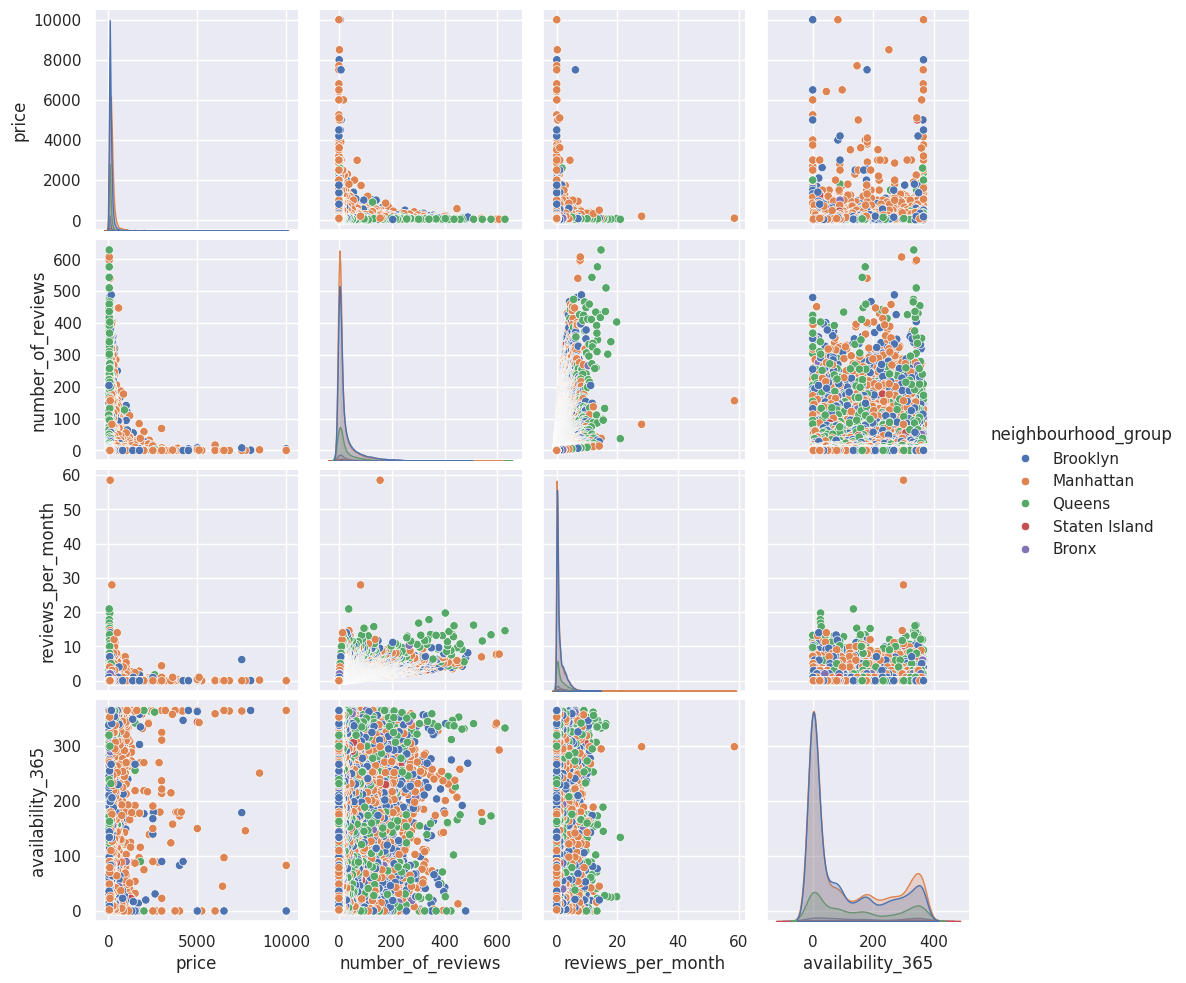

In [15]:
selected_features = df[['neighbourhood_group','price',
       'number_of_reviews',
       'reviews_per_month',
       'availability_365']]

sns.pairplot(data=selected_features, hue='neighbourhood_group')

## AB Testing
### Now that we have cleaned up the dataset and also been given a good view on the distribution of values between the quantitative variables and each neighborhood group, we'll move to AB testing

### Specifically we want to see if numbers of reviews over a certain threshold leads to more bookings for a host 

In [16]:
# first we need to look a bit more into the data to see the max and minimums for the numbers of reviews and bookings for a listing
print(f'Max reviews: {df.number_of_reviews.max()}\nMax reviews per month: {df.reviews_per_month.max()}')

Max reviews: 629
Max reviews per month: 58.5


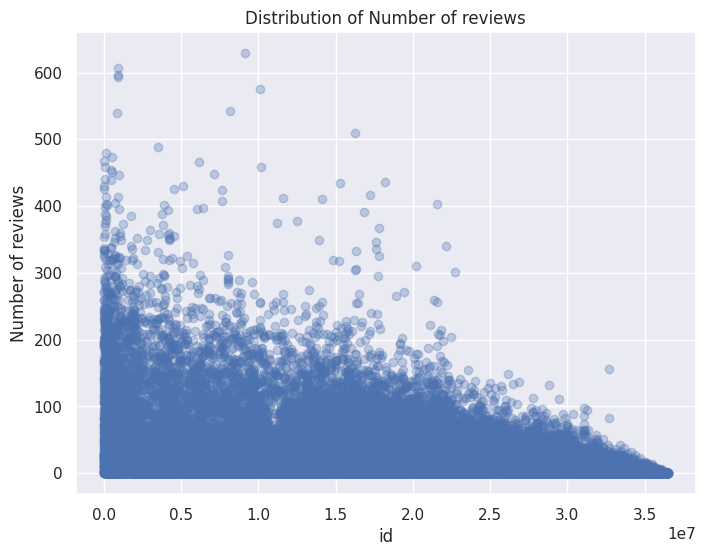

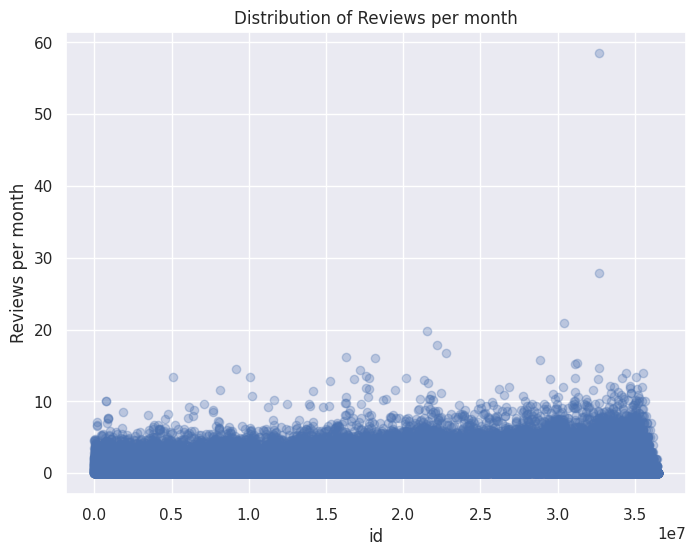

In [17]:

def plot_column(df, column_name, alpha=0.8):
    """
    Creates a line plot for the given column against the 'id' column.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        column_name (str): The name of the column to be plotted.
        alpha (float, optional): The transparency value for the line plot. Default is 0.8.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df['id'], df[column_name], alpha=alpha)
    ax.set_xlabel('id')
    ax.set_ylabel(column_name.capitalize().replace('_', ' '))
    ax.set_title(f'Distribution of {column_name.replace("_", " ").capitalize()}')
    plt.show()

# to go even deeper, we'll conduct an EDA just to get an idea of the distribution of max reviews and reviews per month
reviews_check = df[['id', 'number_of_reviews', 'reviews_per_month']]

# Plot for 'number_of_reviews'
plot_column(reviews_check, 'number_of_reviews', alpha=0.3)

# Plot for 'reviews_per_month'
plot_column(reviews_check, 'reviews_per_month', alpha=0.3)

In [18]:
# shows that some hosts have multiple listings
print(df.shape)
print(df.host_id.unique().shape)

(48895, 12)
(37457,)


In [19]:
# TODO: I have to perform some form of aggregation and grouping by unique host_ids
# the point is to see how many reviews they have

In [20]:
# checking more statistics on each host to determine what I perform my AB Test on
host_df = df.groupby('host_id')['price'].agg(['mean', 'min', 'max', 'count', 'std']).reset_index()
host_df.sort_values(by='mean', ascending=True)[150:160]


,host_id,mean,min,max,count,std
36456,258671946,27.000000,27,27,1,NaN
15312,17927814,27.000000,27,27,1,NaN
20879,35510045,27.000000,27,27,1,NaN
32441,161743285,27.000000,27,27,1,NaN
25222,57398859,27.000000,27,27,1,NaN
35428,232778333,27.000000,25,29,2,2.828427
28955,101970559,27.166667,0,50,6,22.613418
7454,4878363,27.500000,25,30,2,3.535534
31908,153371127,27.500000,27,28,2,0.707107
31504,145242566,27.500000,25,30,2,3.535534


In [21]:
# checking more statistics on each host to determine what I perform my AB Test on
host_df1 = df.groupby('host_id')['price'].agg(['mean', 'min', 'max', 'count', 'std']).reset_index()
host_df1.sort_values(by='mean', ascending=False)

,host_id,mean,min,max,count,std
26778,72390391,10000.0,10000,10000,1,NaN
16313,20582832,10000.0,10000,10000,1,NaN
7693,5143901,10000.0,10000,10000,1,NaN
6985,4382127,9999.0,9999,9999,1,NaN
6315,3906464,9999.0,9999,9999,1,NaN
...,...,...,...,...,...,...
33762,197169969,10.0,10,10,1,NaN
34080,205820814,10.0,10,10,1,NaN
37092,268138154,10.0,10,10,1,NaN
11495,10132166,0.0,0,0,1,NaN


In [22]:
# when we check both, we see that we need to possibly remove a few hosts
# this is because as they have listings with no price.
# We may also have a limit behind it as a 10 dollar listing isnt realistic

print(df.shape)
df.drop(df[df['price'] < 1].index, inplace = True)
print(df.shape)

(48895, 12)
(48884, 12)


In [23]:
# looking to clean the data for ab testing even more by making the availability constant as that can affect number of reviews
df[(df['availability_365'] >= 121) & (df['neighbourhood_group'] == 'Manhattan')].shape

(8123, 12)

In [24]:
# now we have a good enough size for what we are looking for so we will create the testing dataframe
testing_df = df[(df['availability_365'] >= 121) & (df['neighbourhood_group'] == 'Manhattan')]
testing_df.shape


(8123, 12)

### cleaned dataframe statistics

In [25]:
# for the cleaned dataframe
testing_df.number_of_reviews.agg(['mean', 'median'])
price_filter = (testing_df['price'] >= 50) & (testing_df['price'] <= 150)
filtered_df = testing_df[price_filter]

# Calculate the mean and median number of reviews for the filtered DataFrame
filtered_df['number_of_reviews'].agg(['mean', 'median'])

mean      37.415056
median    10.000000
Name: number_of_reviews, dtype: float64

In [26]:
# for the cleaned dataframe
testing_df.number_of_reviews.agg(['mean', 'median'])
price_filter_1 = (testing_df['price'] > 150) & (testing_df['price'] <= 300)
filtered_df = testing_df[price_filter_1]

# Calculate the mean and median number of reviews for the filtered DataFrame
filtered_df['number_of_reviews'].agg(['mean', 'median'])

mean      26.114717
median     4.000000
Name: number_of_reviews, dtype: float64

### original dataframe statistics

In [27]:
df.number_of_reviews.agg(['mean', 'median'])
price_filter_2 = (df['price'] >= 50) & (df['price'] <= 150)
filtered_df2 = df[price_filter_2]

# Calculate the mean and median number of reviews for the filtered DataFrame
filtered_df2['number_of_reviews'].agg(['mean', 'median'])

mean      25.601901
median     6.000000
Name: number_of_reviews, dtype: float64

In [28]:
df.number_of_reviews.agg(['mean', 'median'])
price_filter_3 = (df['price'] > 150) & (df['price'] <= 300)
filtered_df3 = df[price_filter_3]

# Calculate the mean and median number of reviews for the filtered DataFrame
filtered_df3['number_of_reviews'].agg(['mean', 'median'])

mean      21.510491
median     5.000000
Name: number_of_reviews, dtype: float64

## Testing to see if higher priced listings will attract slightly less reviews in comparison to lower priced listings in Manhattan.
- We primarily want to see this between two common price ranges for listings($50-$150 and $151-$300)
- We have the current number of reviews for less priced listings averaging at roughly 37.5 reviews and we believe that the higher priced ones will have less and we predict it to average 30 reviews
- Additionally, we are limiting the data to listings where the posting is available for more than a third of the year to remove bias from listings that are barely available

In [29]:
# quick refresher of the dataset that will be used for the AB test
testing_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,Entire home/apt,225,45,2019-05-21,0.38,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,Private room,150,0,1950-01-01,0.00,365
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,Entire home/apt,200,74,2019-06-22,0.59,129
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,Private room,79,430,2019-06-24,3.47,220
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,Entire home/apt,150,160,2019-06-09,1.33,188


In [30]:
# TODO: add in or insert a column to classify the different hosts or postings by treatment or control group

### Currently, there are on average

In [31]:
# setting up the effective size and required sample size needed for testing based on the minimum difference of improvement we are checking for
# mean number of reviews for the price range between 151 and 300 including 151
effect_size = sms.proportion_effectsize((37.415056/100), (30/100)) # value for the testing df is 25.292673

required_n = sms.NormalIndPower().solve_power(
    effect_size=effect_size,
    power=.80,
    alpha=.05,
    ratio=1,
)

required_n = ceil(required_n)

print(f'Effective size is: {effect_size} and required n(sample size) is {required_n}')

Effective size is: 0.157081596678448 and required n(sample size) is 637


### now we need to check that there are no users sampled multiple times.
### this means host_ids that have multiple listings will be removed

In [32]:
host_id_counts = testing_df['host_id'].value_counts()

multi_hosts = host_id_counts[host_id_counts > 1].value_counts

multi_hosts

<bound method IndexOpsMixin.value_counts of host_id
219517861    312
107434423    207
30283594     121
16098958      91
12243051      88
            ... 
26270573       2
2333904        2
16978120       2
53978622       2
4113106        2
Name: count, Length: 750, dtype: int64>

In [33]:
# we will drop the hosts with multiple listings from the df to be used
print(testing_df.shape)
hosts_to_drop = host_id_counts[host_id_counts > 1].index

testing_df = testing_df[~testing_df['host_id'].isin(hosts_to_drop)]
testing_df.shape

(8123, 12)


(3958, 12)

## now that the dataset does not include any hosts with multiple listings we can dive into creating the groups
## Before this we need to insert a column that classifies whether a listing is highly priced or lowly priced

In [34]:
testing_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,last_review,reviews_per_month,availability_365
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,Private room,150,0,1950-01-01,0.00,365
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,Entire home/apt,200,74,2019-06-22,0.59,129
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,Private room,79,430,2019-06-24,3.47,220
13,6021,Wonderful Guest Bedroom in Manhattan for SINGLES,11528,Claudio,Manhattan,Upper West Side,Private room,85,113,2019-07-05,0.91,333
19,7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,Entire home/apt,190,0,1950-01-01,0.00,249


In [35]:
# insert new column
testing_df.insert(10,"Pricing Category",["high price" if cost > 150 else "low price" for cost in testing_df['price']])
testing_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,number_of_reviews,last_review,Pricing Category,reviews_per_month,availability_365
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,Private room,150,0,1950-01-01,low price,0.00,365
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,Entire home/apt,200,74,2019-06-22,high price,0.59,129
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,Private room,79,430,2019-06-24,low price,3.47,220
13,6021,Wonderful Guest Bedroom in Manhattan for SINGLES,11528,Claudio,Manhattan,Upper West Side,Private room,85,113,2019-07-05,low price,0.91,333
19,7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,Entire home/apt,190,0,1950-01-01,high price,0.00,249


In [37]:
pd.crosstab(testing_df['Pricing Category'],testing_df['room_type']) # TODO: create treatment and control groups based on one of the id columns

room_type,Entire home/apt,Private room,Shared room
Pricing Category,,,
high price,2055,199,9
low price,593,1042,60
